In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import PIL
from keras import layers, optimizers
from keras.models import Model, model_from_json, Sequential
from keras.layers import Input, Activation, Dense, Conv2D, Flatten, ZeroPadding2D, BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D, Dropout, GlobalMaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from random import seed 
from random import randint

Using TensorFlow backend.


In [2]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
from PIL import Image

In [3]:
from keras.applications import VGG16
vgg_conv = VGG16(weights = 'imagenet', include_top = True)

In [4]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
for i in range(3):
    vgg_conv.layers.pop()
vgg_conv.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
X = vgg_conv.layers[-1].output
X = Dense(256, activation = 'relu', name = 'fc_1')(X)
X = Dense(256, activation = 'relu', name = 'fc_2')(X)
X = Dense(3, activation = 'softmax', name = 'predictions')(X)
model_vgg = Model(vgg_conv.input, X)
print(model_vgg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
for l in model_vgg.layers[:-8]:
    l.trainable = False
for layer in model_vgg.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002730771B648> False
<keras.layers.convolutional.Conv2D object at 0x0000027308701EC8> False
<keras.layers.convolutional.Conv2D object at 0x0000027308701508> False
<keras.layers.pooling.MaxPooling2D object at 0x000002730884B9C8> False
<keras.layers.convolutional.Conv2D object at 0x00000273088A3688> False
<keras.layers.convolutional.Conv2D object at 0x0000027308701B48> False
<keras.layers.pooling.MaxPooling2D object at 0x00000273088B1FC8> False
<keras.layers.convolutional.Conv2D object at 0x00000273088BB208> False
<keras.layers.convolutional.Conv2D object at 0x00000273088BEF08> False
<keras.layers.convolutional.Conv2D object at 0x00000273088C69C8> False
<keras.layers.pooling.MaxPooling2D object at 0x00000273088CB388> False
<keras.layers.convolutional.Conv2D object at 0x00000273088DB388> False
<keras.layers.convolutional.Conv2D object at 0x00000273088DE3C8> False
<keras.layers.convolutional.Conv2D object at 0x00000273088E57C8> False
<ker

In [8]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_batchsize = 106
validation_batchsize = 19

train_generator = train_datagen.flow_from_directory('Transfer_Train',
                                 target_size = (224, 224),
                                 batch_size = train_batchsize,
                                 class_mode = 'categorical',
                                 )

validation_generator = validation_datagen.flow_from_directory('Transfer_vali',
                                 target_size = (224, 224),
                                 batch_size = validation_batchsize,
                                 class_mode = 'categorical',
                                 shuffle = False,
                                 )

Found 297 images belonging to 3 classes.
Found 89 images belonging to 3 classes.


In [15]:
#model_vgg.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 1e-5), metrics = ['accuracy'])
history = model_vgg.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples//train_generator.batch_size,
                              epochs = 10,
                              validation_data = validation_generator,
                              validation_steps=validation_generator.samples//validation_generator.batch_size,
                              verbose = 1)

Epoch 1/10
2/2 [==============================] - 141s 71s/step - loss: 0.1980 - acc: 0.9245 - val_loss: 0.4841 - val_acc: 0.7714
Epoch 2/10
2/2 [==============================] - 101s 51s/step - loss: 0.1998 - acc: 0.9302 - val_loss: 0.4336 - val_acc: 0.7857
Epoch 3/10
2/2 [==============================] - 106s 53s/step - loss: 0.2011 - acc: 0.9374 - val_loss: 0.4263 - val_acc: 0.8158
Epoch 4/10
2/2 [==============================] - 112s 56s/step - loss: 0.2210 - acc: 0.9387 - val_loss: 0.3481 - val_acc: 0.9000
Epoch 5/10
2/2 [==============================] - 103s 51s/step - loss: 0.1573 - acc: 0.9578 - val_loss: 0.5309 - val_acc: 0.7714
Epoch 6/10
2/2 [==============================] - 105s 52s/step - loss: 0.2167 - acc: 0.9333 - val_loss: 0.5032 - val_acc: 0.7714
Epoch 7/10
2/2 [==============================] - 112s 56s/step - loss: 0.1426 - acc: 0.9717 - val_loss: 0.3761 - val_acc: 0.8571
Epoch 8/10
2/2 [==============================] - 106s 53s/step - loss: 0.2073 - acc: 0.94

In [11]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


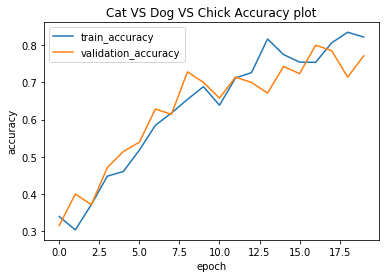

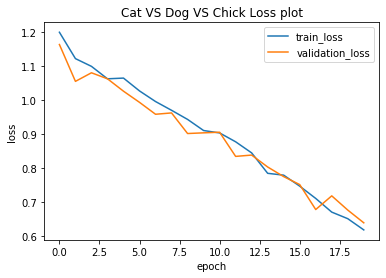

In [12]:
plot_accuracy(history,'Cat VS Dog VS Chick Accuracy plot')
plot_loss(history,'Cat VS Dog VS Chick Loss plot')

In [22]:
from keras.preprocessing.image import load_img, save_img
class_list = ['Cat','Chick','Dog']

def predict_class(model, images, show = True):
    for img in images:
        img = load_img(img, target_size=(224, 224))
        img = img_to_array(img)                    
        img = np.expand_dims(img, axis=0)         
        img /= 255
        pred = model.predict(img)
        index = np.argmax(pred)
        class_list.sort()
        pred_value = class_list[index]   
        if show:
            plt.imshow(img[0])                           
            plt.axis('off')
            plt.title(pred_value)
            plt.show()

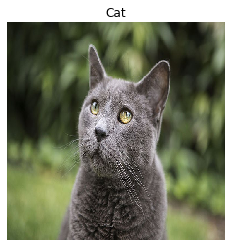

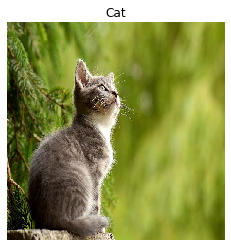

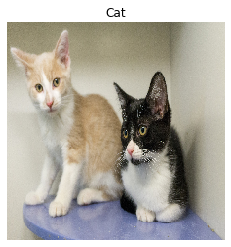

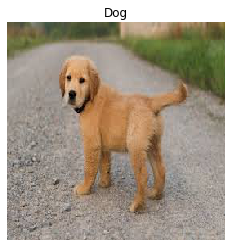

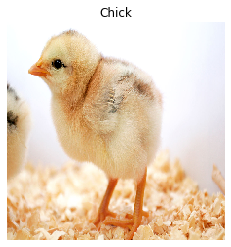

In [25]:
testing = []
testing.append("test13.jpg")
testing.append("test14.jpg")
testing.append("test15.jpg")
testing.append("test17.jpg")
testing.append("test18.jpg")
predict_class(model_vgg, testing, True)

In [26]:
import h5py

In [27]:
model_json = model_vgg.to_json()
with open("ASIRA_transfer_model.json", "w") as json_file:
    json_file.write(model_json)

In [1]:
model_vgg.save_weights("ASIRA_model_transfer_learn_weights.h5")
print("Saved")

NameError: name 'model_vgg' is not defined